# **Preparing Data**

In [ ]:
#Filtering airlines which have 100 reviews

#import data

import pandas as pd

airlines = pd.read_csv('/content/Airline_Reviews.csv')

review_count = airlines.groupby('Airline Name').size().reset_index(name = 'review count')

reviews100 = review_count[review_count['review count']==100]['Airline Name']

data_i = airlines[airlines['Airline Name'].isin(reviews100)]

In [ ]:
#Handling textual missing data values by replacing with N/A

data_i['Airline Name'].fillna('N/A', inplace = True)
data_i['Review_Title'].fillna('N/A', inplace = True)
data_i['Review Date'].fillna('N/A', inplace = True)
data_i['Verified'].fillna('N/A', inplace = True)
data_i['Review'].fillna('N/A', inplace = True)
data_i['Aircraft'].fillna('N/A', inplace = True)
data_i['Type Of Traveller'].fillna('N/A', inplace = True)
data_i['Seat Type'].fillna('N/A', inplace = True)
data_i['Route'].fillna('N/A', inplace = True)
data_i['Date Flown'].fillna('N/A', inplace = True)

#removing leading and trailing spaces

data_i_one = data_i.applymap(lambda x: x.strip() if isinstance(x, str) else x)

#handling missing values in numeric columns by replacing with mean

data_i_one['Seat Comfort'].fillna(data_i_one['Seat Comfort'].mean(), inplace=True)
data_i_one['Cabin Staff Service'].fillna(data_i_one['Cabin Staff Service'].mean(), inplace=True)
data_i_one['Food & Beverages'].fillna(data_i_one['Food & Beverages'].mean(), inplace=True)
data_i_one['Ground Service'].fillna(data_i_one['Ground Service'].mean(), inplace=True)
data_i_one['Inflight Entertainment'].fillna(data_i_one['Inflight Entertainment'].mean(), inplace=True)
data_i_one['Wifi & Connectivity'].fillna(data_i_one['Wifi & Connectivity'].mean(), inplace=True)
data_i_one['Value For Money'].fillna(data_i_one['Value For Money'].mean(), inplace=True)

#round the values to the nearest whole number

data_i_one['Seat Comfort'] = data_i_one['Seat Comfort'].round()
data_i_one['Cabin Staff Service'] = data_i_one['Cabin Staff Service'].round()
data_i_one['Food & Beverages'] = data_i_one['Food & Beverages'].round()
data_i_one['Ground Service'] = data_i_one['Ground Service'].round()
data_i_one['Inflight Entertainment'] = data_i_one['Inflight Entertainment'].round()
data_i_one['Wifi & Connectivity'] = data_i_one['Wifi & Connectivity'].round()
data_i_one['Value For Money'] = data_i_one['Value For Money'].round()

#assigning 5 levels of satisfaction to the numeric columns to convert into textual data

# Define a mapping dictionary for ratings to be assigned to satisfaction levels

rating_to_satisfaction = {
    0: 'N/A',
    1: 'Very Dissatisfied',
    2: 'Dissatisfied',
    3: 'Neutral',
    4: 'Satisfied',
    5: 'Very Satisfied'
}

#mapping the dictionary to each numeric column

data_i_one['Seat Comfort'] = data_i_one['Seat Comfort'].map(rating_to_satisfaction)
data_i_one['Cabin Staff Service'] = data_i_one['Cabin Staff Service'].map(rating_to_satisfaction)
data_i_one['Food & Beverages'] = data_i_one['Food & Beverages'].map(rating_to_satisfaction)
data_i_one['Ground Service'] = data_i_one['Ground Service'].map(rating_to_satisfaction)
data_i_one['Inflight Entertainment'] = data_i_one['Inflight Entertainment'].map(rating_to_satisfaction)
data_i_one['Wifi & Connectivity'] = data_i_one['Wifi & Connectivity'].map(rating_to_satisfaction)
data_i_one['Value For Money'] = data_i_one['Value For Money'].map(rating_to_satisfaction)

#changing the textual date column to proper date format
data_i_one['Review Date'] = pd.to_datetime(data_i_one['Review Date'])
data_i_one['Date Flown'] = pd.to_datetime(data_i_one['Date Flown'], errors='coerce')

#handling missing values in the 'Date Flown' column
data_i_one['Date Flown'].fillna('N/A', inplace = True)
data_i_one['Overall_Rating'].fillna('N/A', inplace = True)

#removing obs with 'n' for overall rating
data_i_one = data_i_one[data_i_one['Overall_Rating'] != 'n']



#splitting route column into 3 columns
pattern = r'(.+) to (.+?)(?: via (.+))?'
data_i_one[['departure', 'destination', 'layover']] = data_i_one['Route'].str.extract(pattern)

new_pattern = r' to (.+?)(?: via |$)'
data_i_one['destination'] = data_i_one['Route'].str.extract(new_pattern)





In [ ]:
filepath = '/content/Airline_cleaned_1.csv'
data_i_one.to_csv(filepath, index=False)

In [ ]:
#drop the 'Unnamed: 0' column

data = data_i_one.drop('Unnamed: 0', axis=1)
data.head()

filepath = '/content/Airline_1.csv'
data.to_csv(filepath, index=False)

In [ ]:
#geocoding api to filter departure to find cities belonging to USA
import requests
def is_in_usa(location):
    # Replace 'YOUR_API_KEY' with your actual Google Maps Geocoding API key
    api_key = ''
    base_url = 'https://maps.googleapis.com/maps/api/geocode/json?'

    # Construct the request URL
    params = {
        'address': location,
        'key': api_key,
    }
    response = requests.get(base_url, params=params)
    data = response.json()

    if 'results' in data:
        for result in data['results']:
            for component in result['address_components']:
                if 'country' in component['types']:
                    if component['short_name'] == 'US':
                        return True
    return False

In [ ]:
# Apply the is_in_usa function to filter the 'locations' column
data['in_usa'] = data['departure'].apply(is_in_usa)

# Filter only the rows where 'in_usa' is True
airlines_usa = data[data['in_usa']]

In [ ]:
#geocoding api to find coutries of the cities on destination column

def geocode_city(city_name, api_key):
    # Construct the Geocoding API URL
    api_key = ''
    base_url = 'https://maps.googleapis.com/maps/api/geocode/json'
    params = {
        'address': city_name,
        'key': api_key,
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    # Extract the country information
    if data['status'] == 'OK':
        for result in data['results']:
            for component in result['address_components']:
                if 'country' in component['types']:
                    return component['long_name']
    else:
        return 'N/A'

In [ ]:
airlines_usa['destination_country'] = airlines_usa['destination'].apply(geocode_city, api_key = '')

In [ ]:
filepath = '/content/Airline_usa.csv'
airlines_usa.to_csv(filepath, index=False)

In [ ]:
import pandas as pd
import numpy as np
airlines = pd.read_csv('/content/Airline_usa (1).csv')


# Droping unwanted columns
columns_to_drop = ["Aircraft","Review Date", "Recommended", "layover","in_usa_destination","in_USA","Value For Money","Verified","Route"]
airlines_USA = airlines.drop(columns=columns_to_drop)
airlines_USA

In [ ]:
filepath = '/content/airlines_USA.csv'
airlines_USA.to_csv(filepath, index=False)

In [ ]:
#assigning TRUE if the destination country is USA
us_countries = ['United States']
airlines_USA['destination_in_USA'] = airlines_USA['destination_country'].apply(lambda x: x in us_countries)
airlines_USA.head()

In [ ]:
# Created a new column to define the flight
airlines_USA['flight_type'] = np.where((airlines_USA['in_usa'] & airlines_USA['destination_in_USA']), 'Domestic', 'International')

airlines_USA.head()

In [ ]:
filepath = 'airlines_in_USA.csv'
airlines_USA.to_csv(filepath, index=False)

In [ ]:
import pandas as pd

airline_revs = pd.read_csv('/content/airlines_in_USA.csv')

airline_revs['Date Flown'] = pd.to_datetime(airline_revs['Date Flown'])
airline_revs['time'] = airline_revs['Date Flown'].dt.time

# Drop the 'time' column if not required
airline_revs.drop(columns=['time'], inplace=True)

filepath = '/content/revs.csv'
airline_revs.to_csv(filepath, index=False)

# **EDA**

In [ ]:
from pickle import TRUE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('/content/revs.csv')

data['Inflight Entertainment'].fillna('N/A', inplace = True)
data['Wifi & Connectivity'].fillna('N/A', inplace = True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2668 entries, 0 to 2667
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Airline Name            2668 non-null   object
 1   Overall_Rating          2668 non-null   int64 
 2   Review_Title            2668 non-null   object
 3   Review                  2668 non-null   object
 4   Type Of Traveller       2668 non-null   object
 5   Seat Type               2668 non-null   object
 6   Date Flown              2668 non-null   object
 7   Seat Comfort            2668 non-null   object
 8   Cabin Staff Service     2668 non-null   object
 9   Food & Beverages        2668 non-null   object
 10  Ground Service          2668 non-null   object
 11  Inflight Entertainment  2668 non-null   object
 12  Wifi & Connectivity     2668 non-null   object
 13  departure               2668 non-null   object
 14  destination             2668 non-null   object
 15  in_u

In [ ]:
print(data.describe())

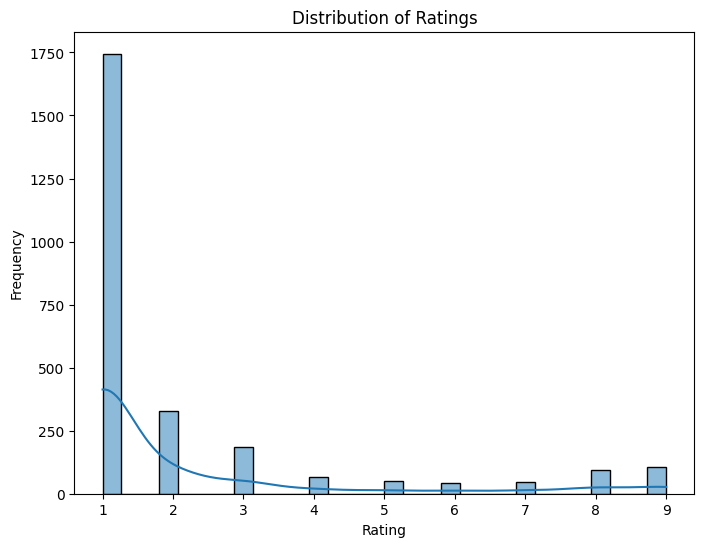

In [ ]:
#distribution of ratings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(data=data, x='Overall_Rating', bins=30, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

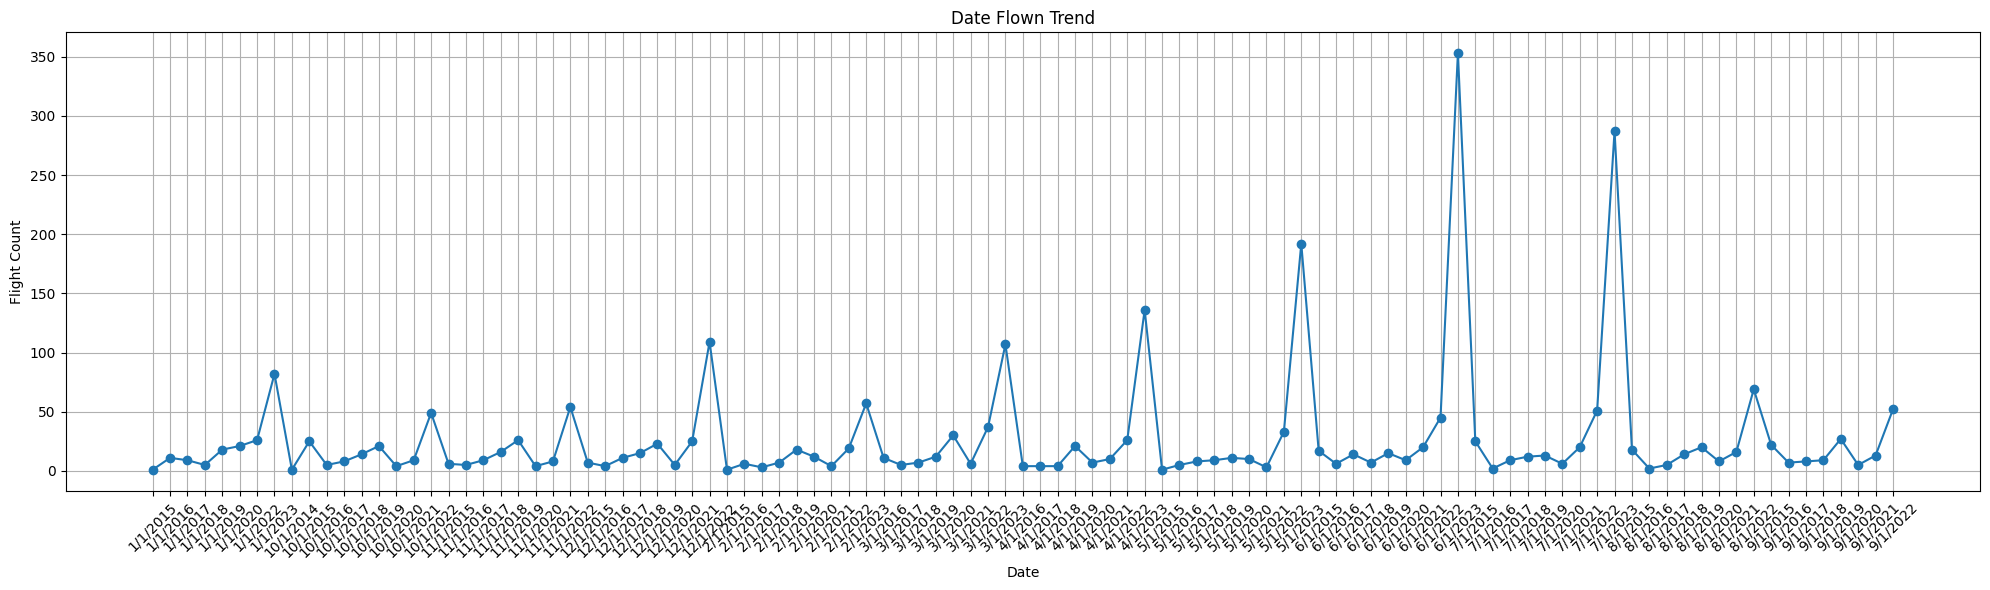

In [ ]:
#Frequency Distribution of Date Flown

date_counts = data['Date Flown'].value_counts().sort_index()

plt.figure(figsize=(20, 6))
plt.plot(date_counts.index, date_counts.values, marker='o', linestyle='-')
plt.title('Date Flown Trend')
plt.xlabel('Date')
plt.ylabel('Flight Count')
plt.grid(True)

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensure proper spacing
plt.show()

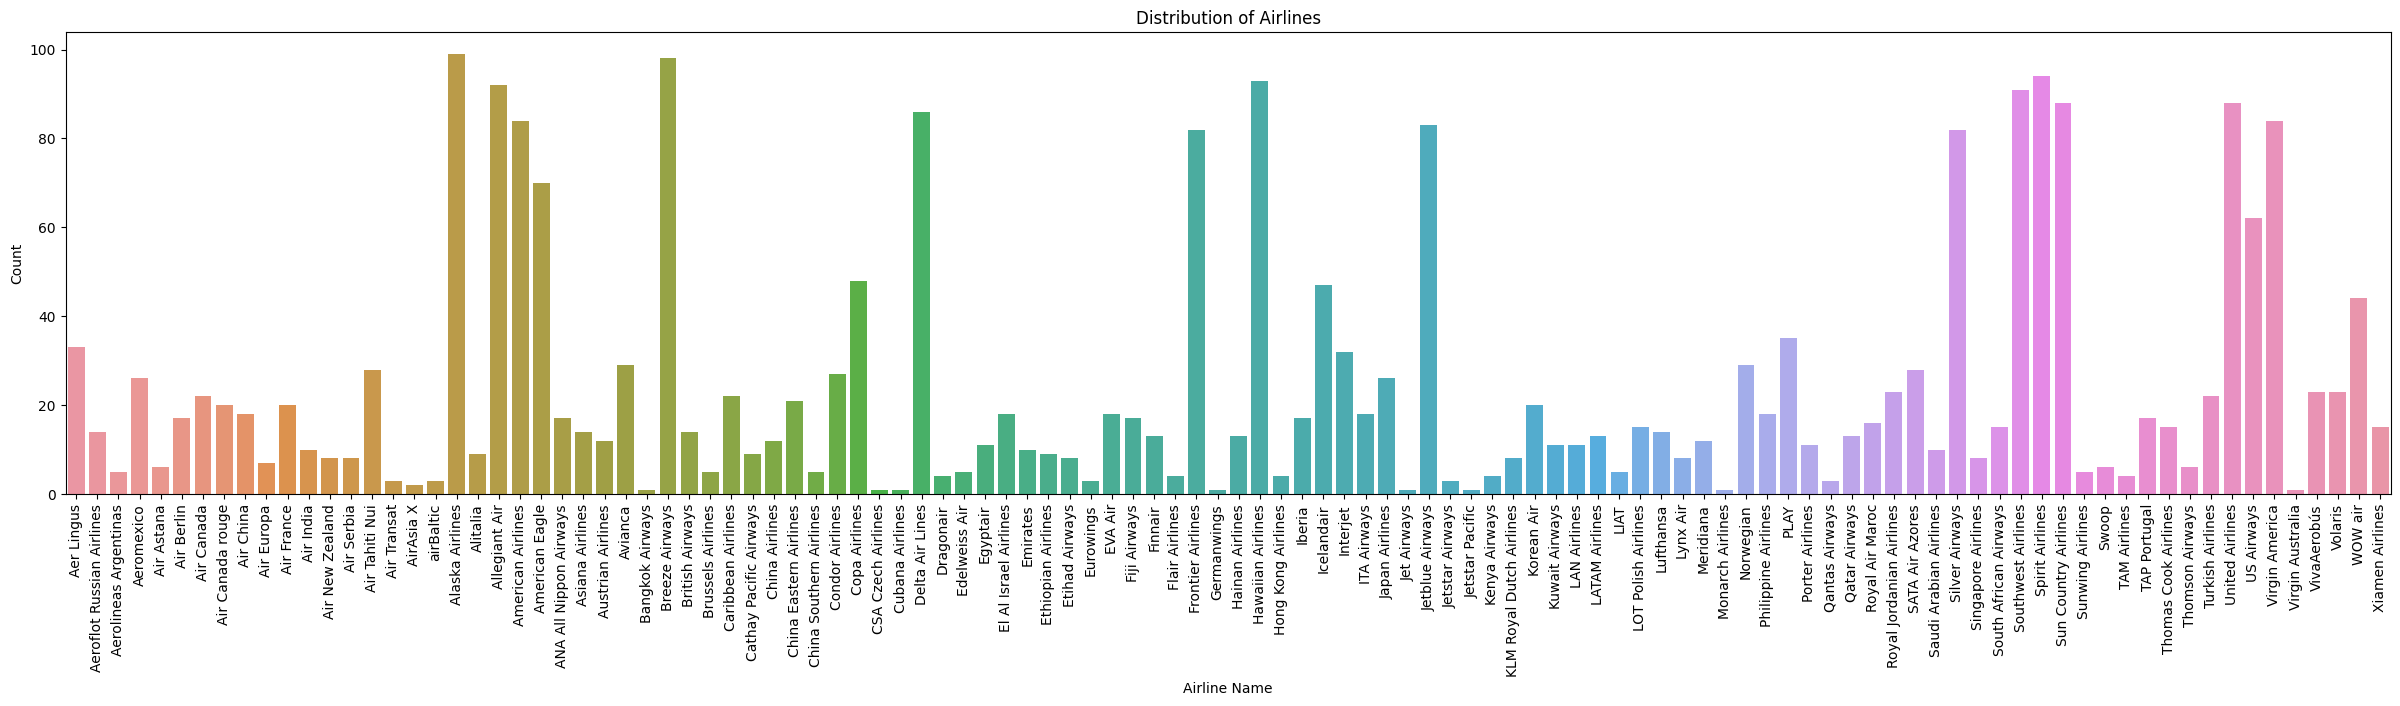

In [ ]:
#Distribution of Airlines

plt.figure(figsize=(30, 6))
sns.countplot(data=data, x='Airline Name')
plt.title('Distribution of Airlines')
plt.xlabel('Airline Name')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

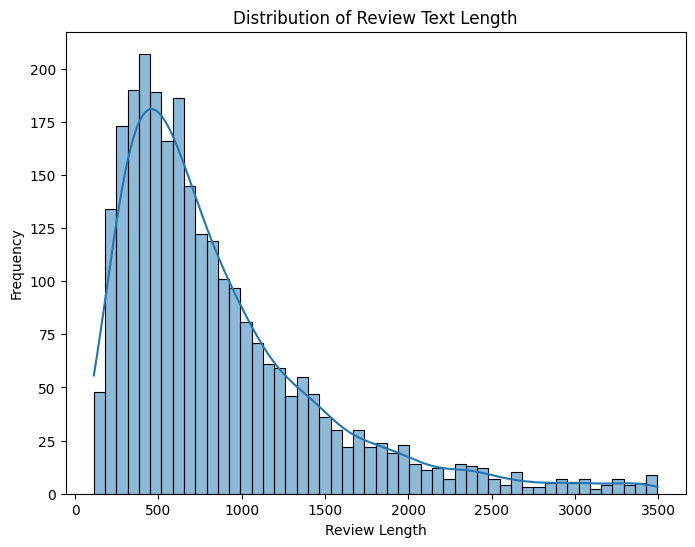

In [ ]:
#distribution of review length

data['review_length'] = data['Review'].apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x='review_length', bins=50, kde=True)
plt.title('Distribution of Review Text Length')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

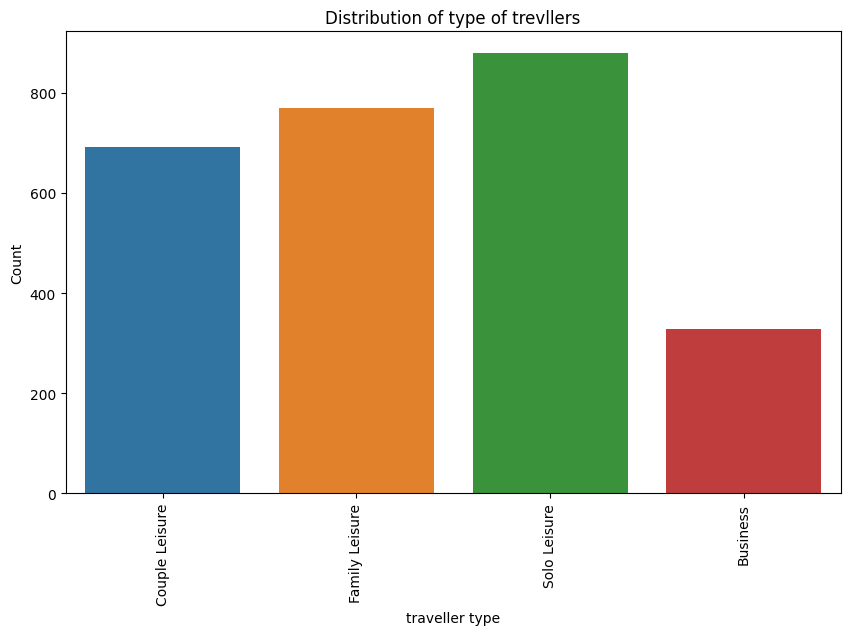

In [ ]:
#distribution of type of travellers

plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Type Of Traveller')
plt.title('Distribution of type of trevllers')
plt.xlabel('traveller type')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

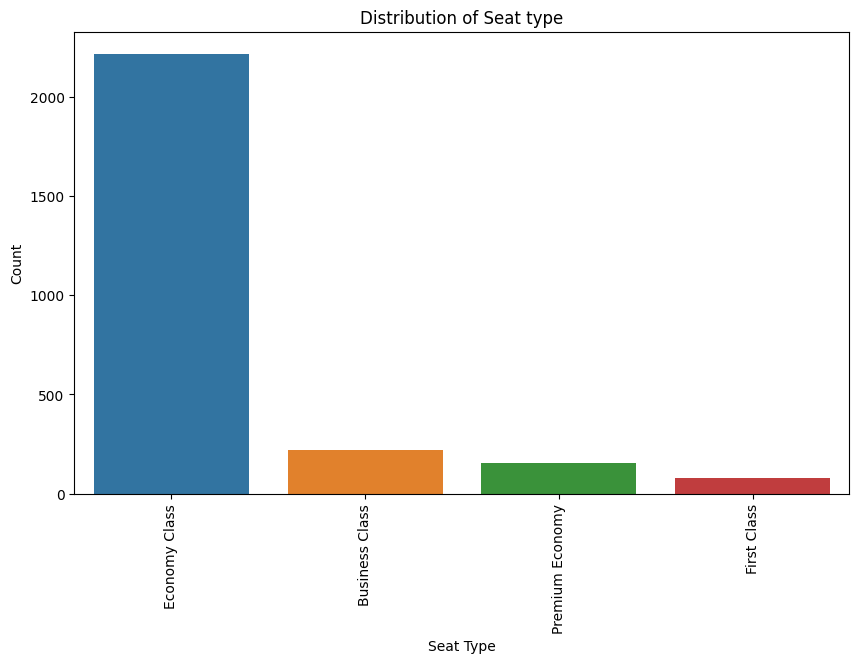

In [ ]:
#distribution of seat type

plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Seat Type')
plt.title('Distribution of Seat type')
plt.xlabel('Seat Type')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

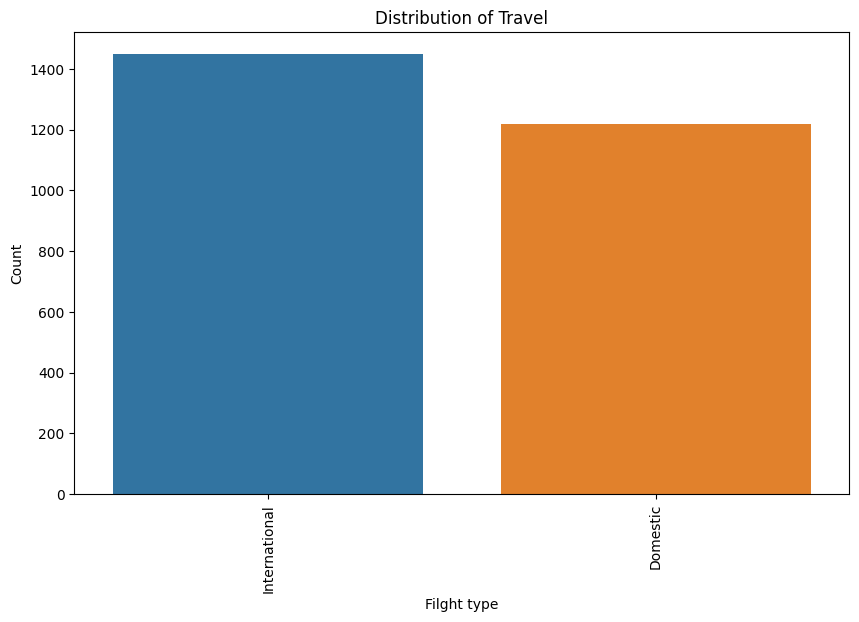

In [ ]:
#distribution of Domestic and International
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='flight_type')
plt.title('Distribution of Travel')
plt.xlabel('Filght type')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [ ]:
#count of type of teveller vs flight type

matrix = pd.crosstab(data['Type Of Traveller'], data['flight_type'], margins=True, margins_name='Total')
print(matrix)

In [ ]:
#count of seat type vs flight type

matrix = pd.crosstab(data['Seat Type'], data['flight_type'], margins=True, margins_name='Total')
print(matrix)

NameError: ignored

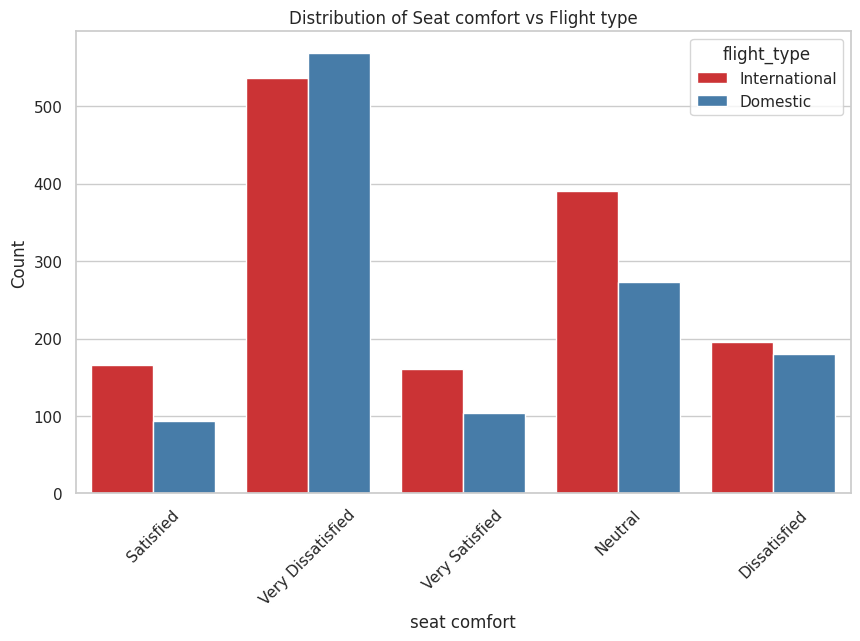

In [ ]:
#distribution of Seat comfort vs flight type
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Seat Comfort', hue='flight_type', palette='Set1')
plt.title('Distribution of Seat comfort vs Flight type')
plt.xlabel('seat comfort')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

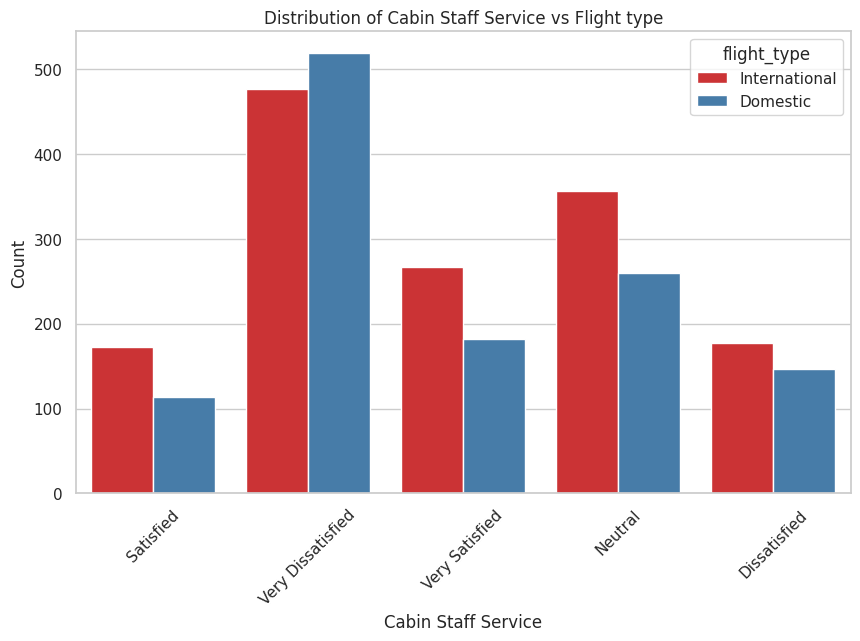

In [ ]:
#distribution of Cabin Staff Service

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Cabin Staff Service', hue='flight_type', palette='Set1')
plt.title('Distribution of Cabin Staff Service vs Flight type')
plt.xlabel('Cabin Staff Service')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

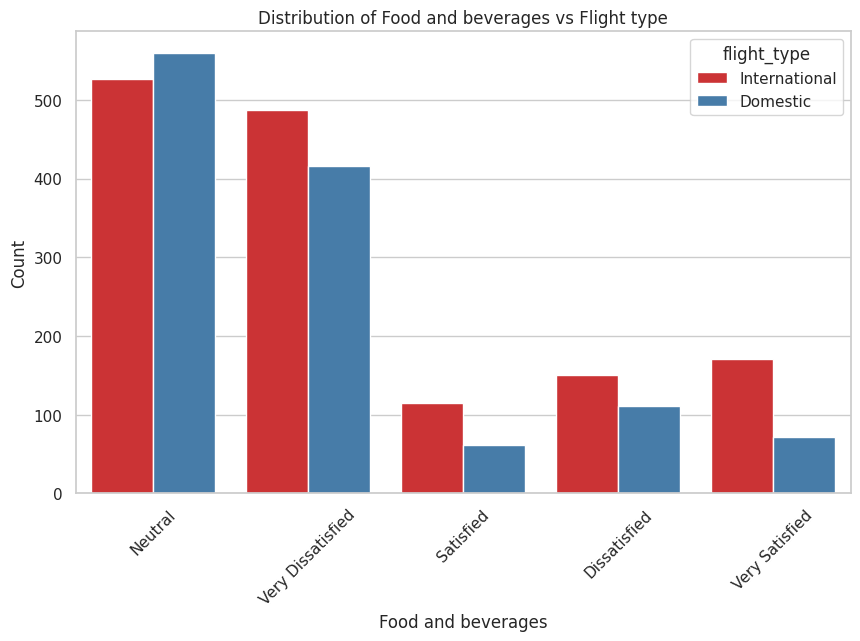

In [ ]:
#distribution of Food and Beverages vs Flight type

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Food & Beverages', hue='flight_type', palette='Set1')
plt.title('Distribution of Food and beverages vs Flight type')
plt.xlabel('Food and beverages')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

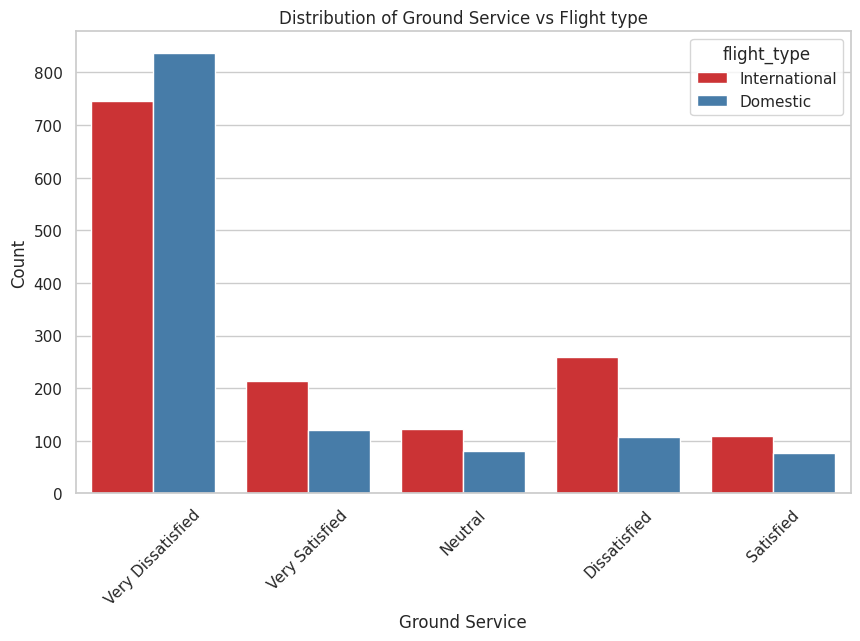

In [ ]:
#distribution of Ground Services vs Flight type

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Ground Service', hue='flight_type', palette='Set1')
plt.title('Distribution of Ground Service vs Flight type')
plt.xlabel('Ground Service')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

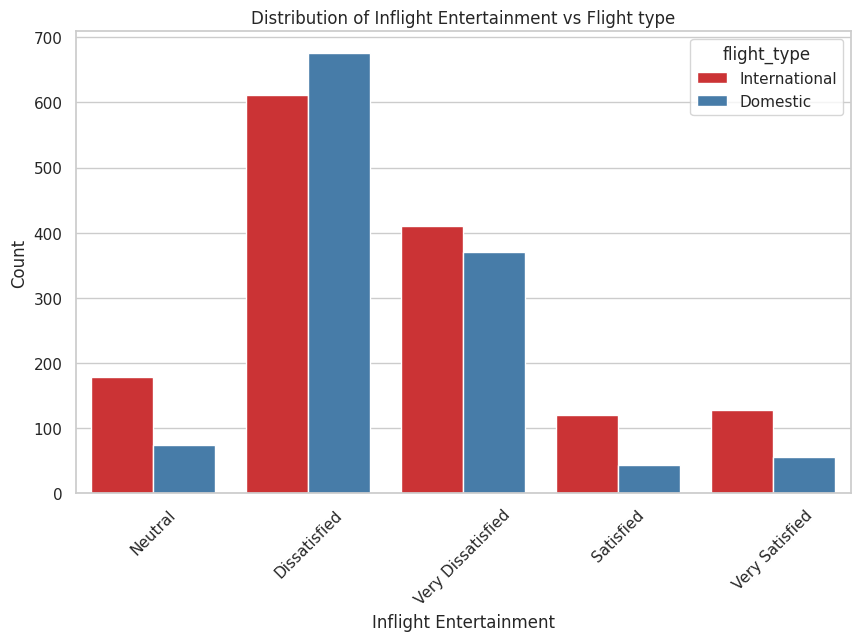

In [ ]:
#distribution of Inflight Entertainment vs Flight type

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Inflight Entertainment', hue='flight_type', palette='Set1')
plt.title('Distribution of Inflight Entertainment vs Flight type')
plt.xlabel('Inflight Entertainment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

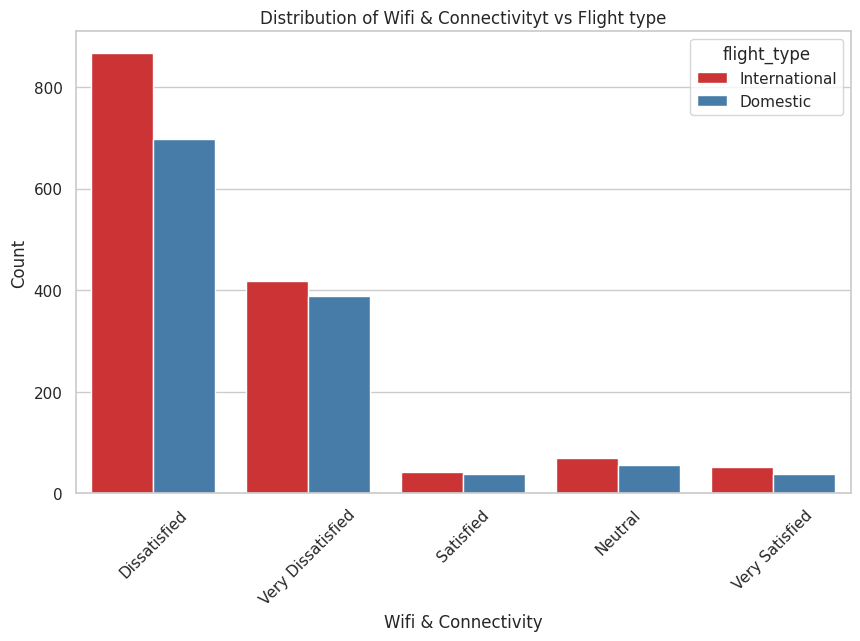

In [ ]:
#distribution of Wifi & Connectivity vs Flight type

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Wifi & Connectivity', hue='flight_type', palette='Set1')
plt.title('Distribution of Wifi & Connectivityt vs Flight type')
plt.xlabel('Wifi & Connectivity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()